In [179]:
import os
import sys
import csv
import time
import json
import datetime
import pickle as pkl
import pandas as pd

In [180]:
import tensorflow as tf

In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
file_path = '/content/drive/My Drive/sp+Ip+sn+In.csv'

In [183]:
df = pd.read_csv(file_path)

In [184]:
df.head()

,text,label
0,Its Holy everyone up is quiet palmdale bbw ove...,0
1,May you all have a peaceful tiredbuthappy deca...,0
2,Costco New York is my a Tastes great and paire...,0
3,each time you shoot a zero you have to give me...,0
4,Facebook strikes again – I liked a few pages o...,1


Preprocessing Instagram Posts

In [185]:
!pip install contractions

In [186]:
!pip install wordninja

In [187]:
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import wordninja

In [188]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [189]:
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

In [190]:
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [207]:
# Text normalization includes many steps.
# Each function below serves a step.

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
  
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def split_concatanated_words(words):
    splits =  []
    for word in words:
       split = wordninja.split(word)
       for split_word in split:
          splits.append(split_word)
    return splits

def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words) 
    words = replace_numbers(words)
    words = remove_stopwords(words)
    # words = stem_words(words)
    words = lemmatize_verbs(words)
    # words = split_concatanated_words(words)
    return words

In [208]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [209]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text

In [210]:
df['text'] = [text_prepare(x) for x in df['text']]
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,holy every quiet palm bb w forty pluses izel p...,0
1,may pea c tire happy decathlon ph decathlon ph...,0
2,cost co new york tast gre pair coup l fri eg g...,0
3,tim shoot zero giv kiss,0
4,facebook strike li k pag makeup company sugges...,1


In [211]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [212]:
! pip install glove_python

In [213]:
#Loading pre-trained glove embeddings
import glove
glove_corpus = glove.Corpus()

In [214]:
import os, requests, shutil

glove_dir = './data/RNN/'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

# These are temporary files if we need to download it from the original source (slow)
data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'

#force_download_from_original=False
download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    
    # First, try to download a pre-prepared file directly...
    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:
        # But, for some reason, RedCatLabs didn't give us the file directly
        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    
        # Get rid of tarfile source (the required text file itself will remain)
        #os.unlink(zipfilepath)
        #os.unlink(os.path.join(data_cache, glove_full_50d))

print("GloVE available locally")

GloVE available locally


In [215]:
# Due to size constraints, only use the first 100k vectors (i.e. 100k most frequently used words)
word_embedding = glove.Glove.load_stanford(glove_100k_50d_path )
word_embedding.word_vectors.shape

(100000, 50)

In [216]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    # glove.6B.50d.txt
    f = open(glove_100k_50d_path, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [217]:
word_embedding.most_similar('king')

[('prince', 0.8236179693335699),
 ('queen', 0.7839043010964116),
 ('ii', 0.7746230030635107),
 ('emperor', 0.7736247624872925)]

In [218]:
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 100000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [219]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [220]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 4740 unique tokens.
(2159, 500)
Total 100000 word vectors.
Done!
Building Model!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           237050    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 64)           21248     
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_13 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 500, 64)           24832     
_______

In [221]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [226]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=10,
                           batch_size=64,
                           verbose=1)

Epoch 1/10
27/27 [==============================] - 67s 2s/step - loss: 0.2240 - accuracy: 0.9149 - val_loss: 0.5539 - val_accuracy: 0.7824
Epoch 2/10
27/27 [==============================] - 66s 2s/step - loss: 0.2007 - accuracy: 0.9323 - val_loss: 0.6182 - val_accuracy: 0.7778
Epoch 3/10
27/27 [==============================] - 67s 2s/step - loss: 0.1570 - accuracy: 0.9450 - val_loss: 0.6095 - val_accuracy: 0.8009
Epoch 4/10
27/27 [==============================] - 67s 2s/step - loss: 0.1265 - accuracy: 0.9531 - val_loss: 0.7286 - val_accuracy: 0.8056
Epoch 5/10
27/27 [==============================] - 67s 2s/step - loss: 0.0880 - accuracy: 0.9739 - val_loss: 0.7722 - val_accuracy: 0.7940
Epoch 6/10
27/27 [==============================] - 67s 2s/step - loss: 0.0764 - accuracy: 0.9774 - val_loss: 0.8514 - val_accuracy: 0.8009
Epoch 7/10
27/27 [==============================] - 68s 3s/step - loss: 0.0660 - accuracy: 0.9826 - val_loss: 0.9846 - val_accuracy: 0.7801
Epoch 8/10
27/27 [==

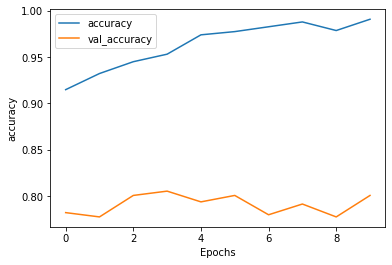

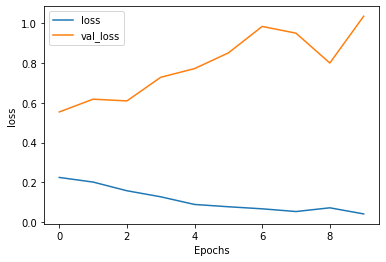

In [227]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [228]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.5772865290823119
INFO:logger:  true positive = 120
INFO:logger:  true negative = 226
INFO:logger:  false positive = 48
INFO:logger:  false negative = 38
INFO:logger:  pricision = 0.7142857142857143
INFO:logger:  recall = 0.759493670886076
INFO:logger:  F1 = 0.736196319018405
INFO:logger:  accuracy = 0.8009259259259259


              precision    recall  f1-score   support

           0       0.86      0.82      0.84       274
           1       0.71      0.76      0.74       158

    accuracy                           0.80       432
   macro avg       0.79      0.79      0.79       432
weighted avg       0.80      0.80      0.80       432



